In [1]:
import pandas as pd
from datetime import datetime
import os
import numpy as np
import matplotlib.pyplot as plt

### Load the data

In [2]:
csvs = os.listdir('data/accepted/')

In [3]:
# make sure all csv files have the same headers
with open("data/accepted/"+csvs[0], 'r') as f:
    columns = f.readlines()[0]
for c in csvs[1:]:
    with open("data/accepted/" + c, 'r') as f:
        if f.readlines()[0] != columns:
            print(c)

In [2]:
dtype = {'id':str,'member_id':str,'loan_amnt':float,'funded_amnt':float,'funded_amnt_inv':float,
         'term':str,'int_rate':str,
         'installment':float,'grade':str,'sub_grade':str,'emp_title':str,'emp_length':str,'home_ownership':str,
         'annual_inc':float,'verification_status':str,'issue_d':str,'loan_status':str,'pymnt_plan':str,'url':str,
         'desc':str,'purpose':str,'title':str,'zip_code':str,'addr_state':str,'dti':float,'delinq_2yrs':float,
         'earliest_cr_line':str,'inq_last_6mths':float,'mths_since_last_delinq':float,
         'mths_since_last_record':float,
         'open_acc':float,'pub_rec':float,'revol_bal':float,'total_acc':float,'initial_list_status':str,
         'out_prncp':float,
         'out_prncp_inv':float,'total_pymnt':float,'total_pymnt_inv':float,'total_rec_prncp':float,
         'total_rec_int':float,
         'total_rec_late_fee':float,'recoveries':float,'collection_recovery_fee':float,'last_pymnt_d':str,
         'last_pymnt_amnt':float,'next_pymnt_d':str,'last_credit_pull_d':str,'collections_12_mths_ex_med':float,
         'mths_since_last_major_derog':float,'policy_code':str,'application_type':str,'annual_inc_joint':float,
         'dti_joint':float,'verification_status_joint':str,'acc_now_delinq':float,'tot_coll_amt':float,
         'tot_cur_bal':float,
         'open_acc_6m':float,'open_act_il':float,'open_il_12m':float,'open_il_24m':float,
         'mths_since_rcnt_il':float,'total_bal_il':float,
         'il_util':str,'open_rv_12m':float,'open_rv_24m':float,'max_bal_bc':float,'all_util':float,
         'total_rev_hi_lim':float,
         'inq_fi':float,'total_cu_tl':float,'inq_last_12m':float,'acc_open_past_24mths':float,'avg_cur_bal':float,
         'bc_open_to_buy':str,'bc_util':str,'chargeoff_within_12_mths':float,'delinq_amnt':float,
         'mo_sin_old_il_acct':str,
         'mo_sin_old_rev_tl_op':str,'mo_sin_rcnt_rev_tl_op':str,'mo_sin_rcnt_tl':str,'mort_acc':float,
         'mths_since_recent_bc':float,'mths_since_recent_bc_dlq':float,'mths_since_recent_inq':float,
         'mths_since_recent_revol_delinq':float,
         'num_accts_ever_120_pd':float,'num_actv_bc_tl':float,'num_actv_rev_tl':float,'num_bc_sats':float,
         'num_bc_tl':float,
         'num_il_tl':float,'num_op_rev_tl':float,'num_rev_accts':float,'num_rev_tl_bal_gt_0':float,'num_sats':float,
         'num_tl_120dpd_2m':float,'num_tl_30dpd':float,'num_tl_90g_dpd_24m':float,'num_tl_op_past_12m':float,
         'pct_tl_nvr_dlq':float,'percent_bc_gt_75':float,'pub_rec_bankruptcies':float,'tax_liens':float,
         'tot_hi_cred_lim':float,
         'total_bal_ex_mort':float,'total_bc_limit':float,'total_il_high_credit_limit':float,'revol_bal_joint':float,
         'sec_app_earliest_cr_line':str,'sec_app_inq_last_6mths':float,'sec_app_mort_acc':str,'sec_app_open_acc':str,
         'sec_app_revol_util':str,'sec_app_open_act_il':str,'sec_app_num_rev_accts':float,
         'sec_app_chargeoff_within_12_mths':float,
         'sec_app_collections_12_mths_ex_med':float,'sec_app_mths_since_last_major_derog':float,'hardship_flag':str,
         'hardship_type':str,'hardship_reason':str,'hardship_status':str,'deferral_term':str,'hardship_amount':float,
         'hardship_start_date':str,'hardship_end_date':str,'payment_plan_start_date':str,'hardship_length':str,
         'hardship_dpd':float,'hardship_loan_status':str,'orig_projected_additional_accrued_interest':float,
         'hardship_payoff_balance_amount':float,'hardship_last_payment_amount':float,'disbursement_method':str,
         'debt_settlement_flag':str,'debt_settlement_flag_date':str,'settlement_status':str,'settlement_date':str,
         'settlement_amount':float,'settlement_percentage':float,'settlement_term':str}

In [5]:
df = pd.DataFrame(columns=dtype.keys())
for i,c in enumerate(csvs):
    df = df.append(pd.read_csv("data/accepted/" + c, dtype=dtype))

In [6]:
print("number of data points: {}".format(len(df)))

number of data points: 1646801


### Drop current and unlabeled borrowers

In [7]:
print(df.loan_status.value_counts(normalize=True))

Current                                                0.492101
Fully Paid                                             0.380819
Charged Off                                            0.097637
Late (31-120 days)                                     0.015266
In Grace Period                                        0.009458
Late (16-30 days)                                      0.003006
Does not meet the credit policy. Status:Fully Paid     0.001207
Does not meet the credit policy. Status:Charged Off    0.000462
Default                                                0.000044
Name: loan_status, dtype: float64


We drop current borrowers, as we are primarily interested in those who have already paid off or charged off on their loans. We save the current borrowers to predict how they will behave for future projects. Note that "Charged Off" means no further payment is expected. This typically occurs when a payment is 150+ days past due. "Default" typically means the borrower has not made a payment for 121+ days, but the account has not been closed or sent to collections yet (see https://help.lendingclub.com/hc/en-us/articles/216127747-What-is-the-difference-between-a-loan-that-is-in-default-and-a-loan-that-has-been-charged-off-)

In [8]:
# drop current borrowers, save for clustering problem
current_df = df[(df.loan_status != 'Fully Paid') & (df.loan_status != 'Charged Off') 
                & (df.loan_status != 'Does not meet the credit policy. Status:Fully Paid')
                & (df.loan_status != 'Does not meet the credit policy. Status:Charged Off')]

In [9]:
current_df.to_csv("data/current_borrowers.csv", index=False)

In [10]:
# drop current borrowers
df = df[df.loan_status!='Current']
df = df[df.loan_status!='In Grace Period']
df = df[df.loan_status!='Late (31-120 days)']
df = df[df.loan_status!='Late (16-30 days)']
df = df[df.loan_status!='Default']
len(df)

790682

We drop the unlabeled data points, as the proportion of unlabeled points (about .003%) is marginal.

In [11]:
print("number of unlabeled points: {}".format(len(df) - df.loan_status.value_counts().sum()))

number of unlabeled points: 23


In [12]:
# drop unlabeled data points (nan)
df = df.dropna(subset=['loan_status'])
len(df)

790659

In [13]:
print(df.loan_status.unique())

['Fully Paid' 'Charged Off'
 'Does not meet the credit policy. Status:Fully Paid'
 'Does not meet the credit policy. Status:Charged Off']


In [14]:
df.loan_status.value_counts()

Fully Paid                                             627124
Charged Off                                            160786
Does not meet the credit policy. Status:Fully Paid       1988
Does not meet the credit policy. Status:Charged Off       761
Name: loan_status, dtype: int64

Observations labeled with "Does not meet the credit policy" are people that borrowed from Lending Club in the past, but would not currently qualify for a loan under Lending Club's current policy. We save them as a separate dataframe for further analysis; perhaps we can identify the change in Lending Club's policy that would cause those borrowers to not qualify for a loan today.

In [15]:
unqualified_df = df[df.loan_status.str.contains("Does not meet the credit policy")]
len(unqualified_df)

2749

In [16]:
unqualified_df.to_csv("data/unqualified_df.csv", index=False)
df = df[(df.loan_status != 'Does not meet the credit policy. Status:Fully Paid') & 
        (df.loan_status != 'Does not meet the credit policy. Status:Charged Off')]

In [17]:
len(df)

787910

### Label the data

In [18]:
df.loan_status = df.loan_status.map({'Fully Paid':1, 'Charged Off':0})
df.loan_status.value_counts()

1    627124
0    160786
Name: loan_status, dtype: int64

In [19]:
df.to_csv('data/labeled.csv', index=False)

### Remove uniform columns

In [3]:
# change loan_status to int, due to encoded labels
dtype['loan_status'] = int
df = pd.read_csv('data/labeled.csv', dtype=dtype)
len(df.columns)

145

In [4]:
# find features with uniform values
for col in df.columns:
    if len(df[col].unique()) == 1:
        print(col, len(df[col].unique()))
        df.drop(col, axis=1, inplace=True)

hardship_flag 1
id 1
member_id 1
next_pymnt_d 1
out_prncp 1
out_prncp_inv 1
policy_code 1
pymnt_plan 1
url 1


### Remove columns with a majority (70% or more) of missing values

In [5]:
null_counts = dict(df.isnull().sum())
null_cols = []
for key,val in null_counts.items():
    if val/df.shape[0] >= .1:
        print(key, '\t', val/df.shape[0])
    if val/df.shape[0] >= 0.7:
        null_cols.append(key)

all_util 	 0.7942696500869388
annual_inc_joint 	 0.9958002817580688
debt_settlement_flag_date 	 0.9854691525681867
deferral_term 	 0.9994567907502125
desc 	 0.8483748143823533
dti_joint 	 0.9958002817580688
hardship_amount 	 0.9994567907502125
hardship_dpd 	 0.9994567907502125
hardship_end_date 	 0.9994567907502125
hardship_last_payment_amount 	 0.9994567907502125
hardship_length 	 0.9994567907502125
hardship_loan_status 	 0.9994567907502125
hardship_payoff_balance_amount 	 0.9994567907502125
hardship_reason 	 0.9994567907502125
hardship_start_date 	 0.9994567907502125
hardship_status 	 0.9994567907502125
hardship_type 	 0.9994567907502125
il_util 	 0.8200835120762524
inq_fi 	 0.7942569582820372
inq_last_12m 	 0.7942582274625275
max_bal_bc 	 0.7942569582820372
mo_sin_old_il_acct 	 0.11267403637471285
mths_since_last_delinq 	 0.5129748321508801
mths_since_last_major_derog 	 0.749250548920562
mths_since_last_record 	 0.8365016308969299
mths_since_rcnt_il 	 0.7988006244368011
mths_since_r

In [6]:
print(len(null_cols))
df.drop(null_cols, axis=1, inplace=True)
print(len(df.columns))

52
84


### Remove columns with majority value (90% or more)

In [7]:
for col in df.drop('loan_status', axis=1).columns:
    if df[col].value_counts(normalize=True).iloc[0] >=.9:
        print(col)
        df.drop(col, axis=1, inplace=True)

acc_now_delinq
application_type
chargeoff_within_12_mths
collections_12_mths_ex_med
debt_settlement_flag
delinq_amnt
disbursement_method
num_tl_120dpd_2m
num_tl_30dpd
num_tl_90g_dpd_24m
tax_liens
total_rec_late_fee


In [8]:
print(df.shape)

(787910, 72)


### Drop columns that aren't helpful or strongly correlated with other features

In [9]:
df['zip_code'].head()

0    860xx
1    309xx
2    606xx
3    917xx
4    972xx
Name: zip_code, dtype: object

In [8]:
# drop the zip_code feature, since we can't work with 3-digit zip codes, and addr_state gives the state
df.drop("zip_code", axis=1, inplace=True)

In [30]:
df['title'].head(10)

0                                 Computer
1                                     bike
2                     real estate business
3                                 personel
4                                 Personal
5    My wedding loan I promise to pay back
6                                     Loan
7                          Car Downpayment
8     Expand Business & Buy Debt Portfolio
9              Building my credit history.
Name: title, dtype: object

In [31]:
# make lower case
df['title'] = df['title'].str.lower()
# got rid of about 10000 categories
print(len(df['title'].unique()))
print(df['title'].isnull().sum())

50798
7387


In [33]:
# keep top x categories
# use substring matching to combine categories (other ways to combine categories)
# make new categories for leftovers
df['title'].value_counts(normalize=True).iloc[:15]

debt consolidation           0.482619
credit card refinancing      0.163980
home improvement             0.051159
other                        0.040810
major purchase               0.015467
consolidation                0.009376
medical expenses             0.008539
business                     0.008346
car financing                0.006965
debt consolidation loan      0.005800
vacation                     0.005336
moving and relocation        0.005216
credit card consolidation    0.004302
personal loan                0.004033
home buying                  0.003472
Name: title, dtype: float64

In [34]:
df['purpose'].value_counts(normalize=True)

debt_consolidation    0.590989
credit_card           0.214731
home_improvement      0.062277
other                 0.053793
major_purchase        0.021473
small_business        0.012644
car                   0.011010
medical               0.010686
moving                0.007026
vacation              0.006258
house                 0.005073
wedding               0.002882
renewable_energy      0.000742
educational           0.000414
Name: purpose, dtype: float64

In [9]:
# drop title (for now), as purpose is a more uniform, consistent way to measure a similar thing (high correlation)
df.drop('title', axis=1, inplace=True)

In [36]:
df.emp_title.head()

0                         NaN
1                       Ryder
2                         NaN
3         AIR RESOURCES BOARD
4    University Medical Group
Name: emp_title, dtype: object

In [37]:
len(df.emp_title.unique())

274750

In [10]:
# for similar reasoning, drop emp_title (user input, very messy)
df.drop('emp_title', axis=1, inplace=True)

In [11]:
# drop sub_grade, as that information can be captured in grade
df.drop('sub_grade', axis=1, inplace=True)

In [12]:
df['total_pymnt'] = df['total_pymnt'].round(2)
df[['total_pymnt','total_pymnt_inv']].head(10)

,total_pymnt,total_pymnt_inv
0,5863.16,5833.84
1,1014.53,1014.53
2,3005.67,3005.67
3,12231.89,12231.89
4,4066.91,4066.91
5,5632.21,5632.21
6,10137.84,10137.84
7,3939.14,3939.14
8,647.50,647.50
9,1484.59,1477.70


In [41]:
df[(np.abs(df['total_pymnt']) <= 1.1*np.abs(df['total_pymnt_inv'])) & (np.abs(df['total_pymnt']) >= .9*np.abs(df['total_pymnt_inv'])) ].shape[0]

783987

In [13]:
# most total_pymnt_inv are nearly the same as total_pymnt
# drop total_pymnt_inv because of high correlation with total_pymnt
df.drop("total_pymnt_inv", axis=1, inplace=True)

In [14]:
# drop issue_d and last_pymnt_d, since new applicants won't have these features
df.drop(['issue_d','last_pymnt_d'], axis=1, inplace=True)

In [15]:
df.shape

(787910, 65)

### Clean features and change to floats/ints

In [45]:
df['term'].head()

0     36 months
1     60 months
2     36 months
3     36 months
4     60 months
Name: term, dtype: object

In [16]:
# change 'term' from string to int
df.term = df.term.apply(lambda x: int(x.split()[0]))
df['term'].head()

0    36
1    60
2    36
3    36
4    60
Name: term, dtype: int64

In [47]:
df['revol_util'].head()

0    83.7%
1     9.4%
2    98.5%
3      21%
4    53.9%
Name: revol_util, dtype: object

In [17]:
# change revol_util to floats
df.revol_util = df.revol_util.str[:-1].astype('float')/100
df.revol_util.head()

0    0.837
1    0.094
2    0.985
3    0.210
4    0.539
Name: revol_util, dtype: float64

In [ ]:
df['last_credit_pull_d'] = pd.to_datetime(df['last_credit_pull_d'])
df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line'])

In [18]:
df['credit_pull_time_diff'] = int(df.last_credit_pull_d.dt.to_period('M') - df.earliest_cr_line.dt.to_period('M'))
df['credit_pull_time_diff'].head()

0    394
1    210
2    187
3    242
4    252
Name: credit_pull_time_diff, dtype: object

In [96]:
df['credit_pull_time_diff'].describe()

count    7.879100e+05
mean    -4.448327e+14
std      6.405205e+16
min     -9.223372e+18
25%      1.620000e+02
50%      2.070000e+02
75%      2.680000e+02
max      8.730000e+02
Name: credit_pull_time_diff, dtype: float64

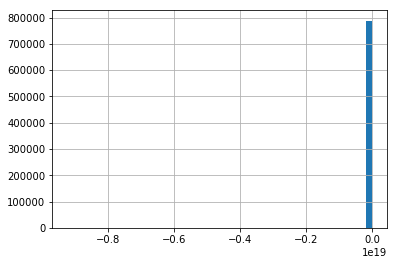

In [98]:
df['credit_pull_time_diff'].hist(bins=50)
plt.show()

In [19]:
# Now we drop earliest_cr_line and last_credit_pull_d because we made a new feature from them
df.drop(['earliest_cr_line', 'last_credit_pull_d'], axis=1, inplace=True)

In [51]:
df['int_rate'].head()

0     10.65%
1     15.27%
2     15.96%
3     13.49%
4     12.69%
Name: int_rate, dtype: object

In [20]:
df.int_rate = df.int_rate.str[:-1].astype('float')/100
df.int_rate.head()

0    0.1065
1    0.1527
2    0.1596
3    0.1349
4    0.1269
Name: int_rate, dtype: float64

In [21]:
df.bc_util = df.bc_util.astype('float')

In [55]:
df.bc_util.tail(10)

787900    12.8
787901    51.7
787902    83.5
787903    20.0
787904    54.2
787905    60.5
787906    68.0
787907    61.7
787908    95.8
787909    48.0
Name: bc_util, dtype: float64

In [22]:
df.bc_open_to_buy = df.bc_open_to_buy.astype('float')

### Fill missing values

In [24]:
# find column with most missing values
df.count().idxmin()

'mths_since_recent_revol_delinq'

In [25]:
df['mths_since_recent_revol_delinq'].isnull().sum()/df.shape[0]

0.6751786371539896

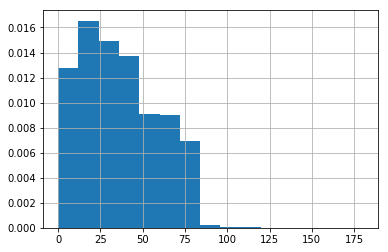

In [26]:
df.mths_since_recent_revol_delinq.hist(bins=15, normed=True)
plt.show()

In [32]:
df.mths_since_recent_revol_delinq.describe()

count    787910.000000
mean         34.044206
std          12.882347
min           0.000000
25%          33.000000
50%          33.000000
75%          33.000000
max         180.000000
Name: mths_since_recent_revol_delinq, dtype: float64

In [28]:
df[~df.mths_since_recent_revol_delinq.isnull()].loan_status.value_counts(normalize=True)

1    0.787708
0    0.212292
Name: loan_status, dtype: float64

In [29]:
df[df.mths_since_recent_revol_delinq.isnull()].loan_status.value_counts(normalize=True)

1    0.799891
0    0.200109
Name: loan_status, dtype: float64

In [31]:
# Fill with median, since "mths_since_recent_revol_delinq" is integer-valued, and slightly skewed left
df["mths_since_recent_revol_delinq"].fillna(df["mths_since_recent_revol_delinq"].median(), inplace=True)

In [33]:
# find column with most missing values
col = df.count().idxmin()
print(col)
df[col].isnull().sum()/df.shape[0]

mths_since_last_delinq


0.5129748321508801

In [34]:
df[~df.mths_since_last_delinq.isnull()].loan_status.value_counts(normalize=True)

1    0.789061
0    0.210939
Name: loan_status, dtype: float64

In [35]:
df[df.mths_since_last_delinq.isnull()].loan_status.value_counts(normalize=True)

1    0.802458
0    0.197542
Name: loan_status, dtype: float64

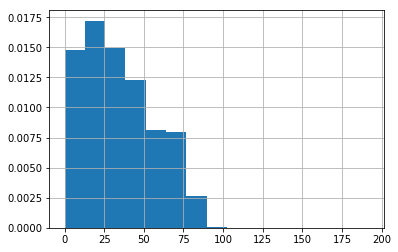

In [36]:
df.mths_since_last_delinq.hist(bins=15, normed=True)
plt.show()

In [37]:
df['mths_since_last_delinq'].describe()

count    383732.000000
mean         34.524348
std          21.946122
min           0.000000
25%          16.000000
50%          31.000000
75%          50.000000
max         192.000000
Name: mths_since_last_delinq, dtype: float64

In [40]:
# Fill with median, since "mths_since_last_delinq" is integer-valued, and slightly skewed left
df["mths_since_last_delinq"].fillna(df["mths_since_last_delinq"].median(), inplace=True)

In [41]:
df.acc_open_past_24mths.describe()

count    740629.000000
mean          4.712176
std           3.146878
min           0.000000
25%           2.000000
50%           4.000000
75%           6.000000
max          56.000000
Name: acc_open_past_24mths, dtype: float64

In [42]:
# fill with median since months since is nominal and median and mean are close (not so much skew)
df['acc_open_past_24mths'].fillna(df['acc_open_past_24mths'].median(), inplace=True)

In [43]:
df['avg_cur_bal'].describe()

count    720371.000000
mean      13528.413955
std       16219.021791
min           0.000000
25%        3118.000000
50%        7516.000000
75%       18845.000000
max      958084.000000
Name: avg_cur_bal, dtype: float64

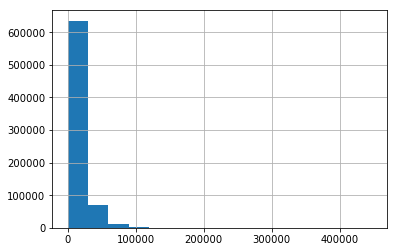

In [44]:
df[df['avg_cur_bal']<463698]['avg_cur_bal'].hist(bins=15)
plt.show()

In [45]:
df[df['avg_cur_bal']<10000].shape

(408615, 64)

In [46]:
# since over 50% of the data is contained when avg_cur_bal < 10000, we fill missing values with median
df['avg_cur_bal'].fillna(df['avg_cur_bal'].median(), inplace=True)

In [47]:
df['bc_open_to_buy'].describe()

count    733034.000000
mean       9436.288340
std       14551.612378
min           0.000000
25%        1304.000000
50%        4240.000000
75%       11299.000000
max      559912.000000
Name: bc_open_to_buy, dtype: float64

In [48]:
# drop bc_open_to_buy because it means "total open-to-buy on revolving bankcards"
# information can be found in (I think) in tot_hi_cred_lim
df.drop('bc_open_to_buy', axis=1, inplace=True)

In [49]:
df['bc_util'].describe()

count    732567.000000
mean         61.644117
std          27.863545
min           0.000000
25%          40.900000
50%          65.500000
75%          86.000000
max         339.600000
Name: bc_util, dtype: float64

In [50]:
# fill with mean (data is not very skewed)
df['bc_util'].fillna(df['bc_util'].mean(), inplace=True)

In [51]:
df['inq_last_6mths'].value_counts()

0.0    427576
1.0    220004
2.0     89382
3.0     36329
4.0     10071
5.0      3577
6.0       900
7.0        48
8.0        22
Name: inq_last_6mths, dtype: int64

In [52]:
# fill with median due to integer values
df['inq_last_6mths'].fillna(df['inq_last_6mths'].median(), inplace=True)

In [53]:
df['dti'].describe()

count    787881.000000
mean         17.832820
std           8.845265
min          -1.000000
25%          11.610000
50%          17.320000
75%          23.580000
max         999.000000
Name: dti, dtype: float64

In [55]:
df[df['dti']==-1]

,acc_open_past_24mths,addr_state,annual_inc,avg_cur_bal,bc_util,collection_recovery_fee,delinq_2yrs,dti,emp_length,funded_amnt,...,total_acc,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,total_pymnt,total_rec_int,total_rec_prncp,total_rev_hi_lim,verification_status,credit_pull_time_diff
645411,8.0,OR,94000.0,8461.0,61.7,0.0,0.0,-1.0,5 years,15000.0,...,24.0,93070.0,10300.0,94043.0,16188.78,1188.78,15000.0,33700.0,Source Verified,170


In [56]:
# fill with mean; data is not skewed
# there is only one value of -1, I thought was impossible and placeholder for NaN
# however, maybe it's possible?
df['dti'].fillna(df['dti'].mean(), inplace=True)

In [57]:
df['mort_acc'].describe()

count    740629.000000
mean          1.764267
std           2.087446
min           0.000000
25%           0.000000
50%           1.000000
75%           3.000000
max          51.000000
Name: mort_acc, dtype: float64

In [58]:
# fill with median (integer-valued)
df['mort_acc'].fillna(df['mort_acc'].median(), inplace=True)

In [60]:
df[df['num_bc_sats'] != df['num_bc_tl']][['num_bc_sats','num_bc_tl']].shape

(672965, 2)

In [61]:
# drop num_bc_tl because (I believe) it's more important than num_bc_sats, and has more missing values
df.drop('num_bc_sats', axis=1, inplace=True)

In [62]:
(df['pub_rec_bankruptcies'] == df['pub_rec']).sum()

748576

In [64]:
df[df['pub_rec_bankruptcies'] != df['pub_rec']]['loan_status'].value_counts(normalize=True)

1    0.758987
0    0.241013
Name: loan_status, dtype: float64

In [66]:
df[(df['pub_rec_bankruptcies'] != df['pub_rec']) & (df['pub_rec_bankruptcies'] > df['pub_rec'])][['pub_rec_bankruptcies','pub_rec']]

,pub_rec_bankruptcies,pub_rec


In [68]:
# Drop pub_rec_bankruptcies, since that information is captured in pub_rec
df.drop('pub_rec_bankruptcies', axis=1, inplace=True)

In [69]:
df['revol_util'].describe()

count    787436.000000
mean          0.530831
std           0.243244
min           0.000000
25%           0.351000
50%           0.538000
75%           0.719000
max           8.923000
Name: revol_util, dtype: float64

In [70]:
# Fill with mean (not skewed) - could figure this out using other variables later
df['revol_util'].fillna(df['revol_util'].mean(), inplace=True)

In [71]:
# drop because 76% are 0, and the remaining have the same distribution of labels as total sample
df.drop("num_accts_ever_120_pd", axis=1, inplace=True)

In [72]:
df['num_actv_bc_tl'].describe()

count    720383.000000
mean          3.635744
std           2.187278
min           0.000000
25%           2.000000
50%           3.000000
75%           5.000000
max          33.000000
Name: num_actv_bc_tl, dtype: float64

In [73]:
# fill with median (integer-valued)
df['num_actv_bc_tl'].fillna(df['num_actv_bc_tl'].median(), inplace=True)

In [74]:
# fill with median (integer-valued)
df['num_actv_rev_tl'].fillna(df['num_actv_rev_tl'].median(), inplace=True)

In [75]:
# fill with median (integer-valued)
df['num_bc_tl'].fillna(df['num_bc_tl'].median(), inplace=True)

In [76]:
# fill with rounded-down mean
df['num_il_tl'].fillna(np.floor(df['num_il_tl'].median()), inplace=True)

In [77]:
# fill with rounded-down mean
df['num_op_rev_tl'].fillna(np.floor(df['num_op_rev_tl'].mean()), inplace=True)

In [78]:
df['num_rev_accts'].fillna(np.floor(df['num_rev_accts'].mean()), inplace=True)

In [79]:
df['num_rev_tl_bal_gt_0'].fillna(df['num_rev_tl_bal_gt_0'].median(), inplace=True)

In [80]:
df['num_sats'].fillna(df['num_sats'].median(), inplace=True)

In [81]:
df['num_tl_op_past_12m'].fillna(df['num_tl_op_past_12m'].median(), inplace=True)

In [82]:
df['pct_tl_nvr_dlq'].describe()

count    720248.000000
mean         94.398238
std           8.384764
min           0.000000
25%          91.700000
50%          98.100000
75%         100.000000
max         100.000000
Name: pct_tl_nvr_dlq, dtype: float64

In [83]:
df['pct_tl_nvr_dlq'].fillna(df['pct_tl_nvr_dlq'].median(), inplace=True)

In [84]:
df['percent_bc_gt_75'].describe()

count    732760.000000
mean         47.331868
std          35.624645
min           0.000000
25%          16.700000
50%          50.000000
75%          75.000000
max         100.000000
Name: percent_bc_gt_75, dtype: float64

In [85]:
df['percent_bc_gt_75'].fillna(df['percent_bc_gt_75'].median(), inplace=True)

In [86]:
# fill with median because of outliers
df['tot_cur_bal'].fillna(df['tot_cur_bal'].median(), inplace=True)

In [87]:
# fill with median because of outliers
df['tot_hi_cred_lim'].fillna(df['tot_hi_cred_lim'].median(), inplace=True)

In [88]:
# fill with median because of outliers
df['total_bal_ex_mort'].fillna(df['total_bal_ex_mort'].median(), inplace=True)

In [89]:
# fill with median because of outliers
df['total_bc_limit'].fillna(df['total_bc_limit'].median(), inplace=True)

In [90]:
# fill with median because of outliers
df['total_il_high_credit_limit'].fillna(df['total_il_high_credit_limit'].median(), inplace=True)

In [91]:
# fill with median because of outliers
df['total_rev_hi_lim'].fillna(df['total_rev_hi_lim'].median(), inplace=True)

In [39]:
months_cols = ['mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op',
               'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl',
               'mths_since_recent_bc', 'mths_since_recent_inq',]
df[months_cols].isnull().sum()/df.shape[0]

mo_sin_old_il_acct       0.112674
mo_sin_old_rev_tl_op     0.085705
mo_sin_rcnt_rev_tl_op    0.085705
mo_sin_rcnt_tl           0.085704
mths_since_recent_bc     0.068910
mths_since_recent_inq    0.146151
dtype: float64

In [92]:
df.isnull().sum()

acc_open_past_24mths                   0
addr_state                             0
annual_inc                             0
avg_cur_bal                            0
bc_util                                0
collection_recovery_fee                0
delinq_2yrs                            0
dti                                    0
emp_length                             0
funded_amnt                            0
funded_amnt_inv                        0
grade                                  0
home_ownership                         0
initial_list_status                    0
inq_last_6mths                         0
installment                            0
int_rate                               0
last_pymnt_amnt                        0
loan_amnt                              0
loan_status                            0
mo_sin_old_il_acct                 88777
mo_sin_old_rev_tl_op               67528
mo_sin_rcnt_rev_tl_op              67528
mo_sin_rcnt_tl                     67527
mort_acc        

In [ ]:
len(df.columns)

In [ ]:
df.to_csv("cleaned_data.csv", index=False)

## SCRATCH

In [ ]:
# MAYBE only keep the first 6 categories of this feature? due to dist.
df.mort_acc.value_counts(normalize=True)